In [1]:
import numpy as np
from scipy.sparse import csr_matrix
import sys
sys.path.append('../../')

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator_rec import MeshDoublePipe
from optimizer import Annealing, AnnealingSolver, PolyTop, AnnealingParameterTuning

# Topology Optimization for Double-pipe Problem

## Computational Mesh

In [2]:
# Create Meshes for double pipe.
n_elem_for_width = 48
n_elem_for_height = 32

mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Conditions

In [3]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
width =1/3
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet_upper' or boundary == 'inlet_lower' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

# Pressure.
BC = []
for boundary in mesh_p.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_p.boundary_nodes[boundary]):
        if boundary == 'inlet_upper' or boundary == 'wall':
            pass
boundary_values_p= np.array(BC)

### Material Properties

In [6]:
viscosity = 1.0; 
density = 1

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density)
fem.set_boudary_values_v(boundary_values_v)

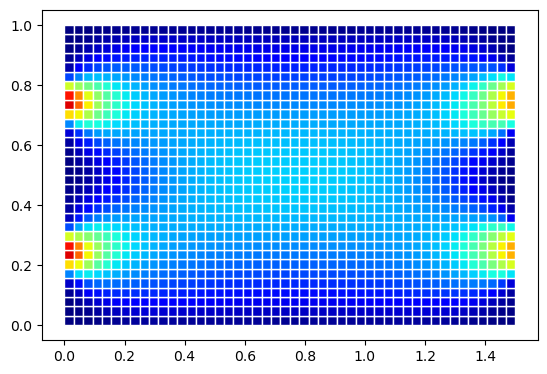

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
coords, elements, boundary_nodes, neighbor_elements=mesh_p.create_mesh_Q1(n_elem_for_width, n_elem_for_height, 1.5, 1.)
from flow_solver import Q2Q1FEM
Q2Q1FEM.Plot_patch(n_elem_for_height,coords,elements,np.sqrt(u_e**2+v_e**2),1.,0,cmap='jet')

## Classical optimization

In [9]:
# Settings for Optimization.
volume_fraction_max = 1/3 # Volume fraction.

density_initial = volume_fraction_max*np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_initial_QA = np.ones(mesh_v.n_elem) # Initial density, i.e., design variables, for each element.
density_min = 0.0; density_max = 1.0 # Lower and upper bound for design variables.

design_tolerance = 0.01 # Convergence tolerance on design variables.
max_iterations = 150 # Max. number of optimization steps.

opt_OCMove = 0.2  # Allowable move step in OC update scheme
opt_OCEta = 0.5  # Exponent used in OC update scheme

q_values = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1] #

############## q = 1e-06 ###############
Iteration: 1, Objective Function: 0.0011037024608507302, Volume Fraction: 0.13900026453656378
Iteration: 2, Objective Function: 0.0011060542920418646, Volume Fraction: 0.0917616151243794
Iteration: 3, Objective Function: 0.0011070678365735181, Volume Fraction: 0.0917611151808756


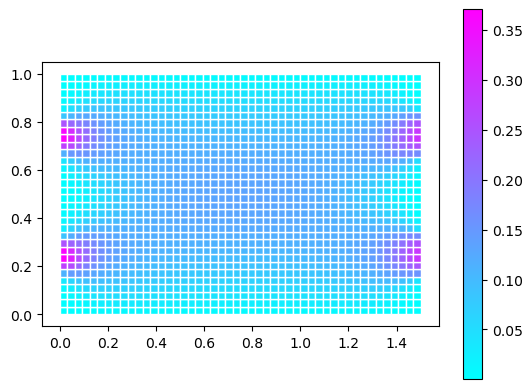

############## q = 1e-05 ###############
Iteration: 1, Objective Function: 0.0011491927133495427, Volume Fraction: 0.2465642822237886
Iteration: 2, Objective Function: 0.0011162442347511289, Volume Fraction: 0.2847190985019458
Iteration: 3, Objective Function: 0.0011130995697709372, Volume Fraction: 0.2893526874864047
Iteration: 4, Objective Function: 0.0011127418548147706, Volume Fraction: 0.2897131958807551
Iteration: 5, Objective Function: 0.0011127175173604941, Volume Fraction: 0.28971319720331684


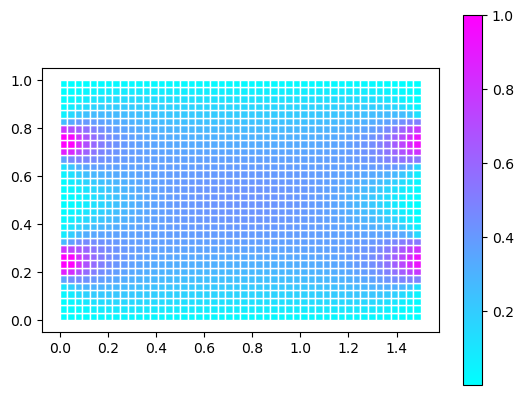

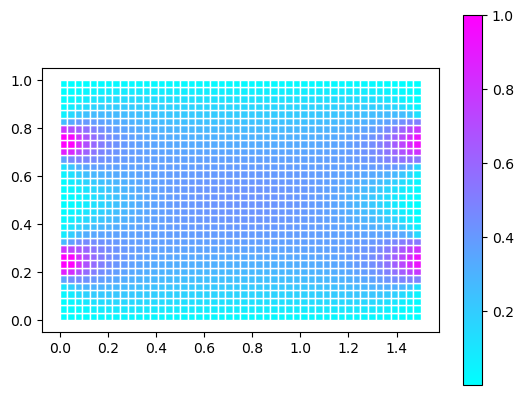

############## q = 0.0001 ##############
Iteration: 1, Objective Function: 0.0012054565305119253, Volume Fraction: 0.3446349841946963
Iteration: 2, Objective Function: 0.0011786915555384218, Volume Fraction: 0.34471677881112406


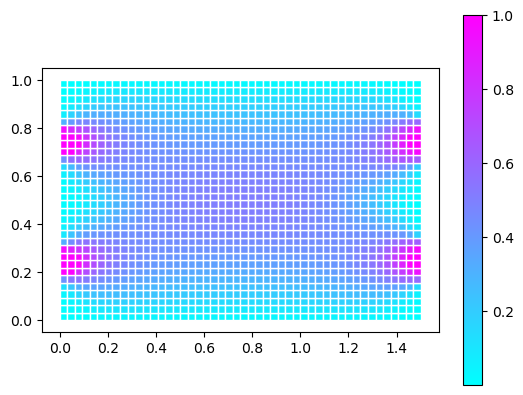

############## q = 0.001 ###############
Iteration: 1, Objective Function: 0.001849885509401857, Volume Fraction: 0.3312671089629358
Iteration: 2, Objective Function: 0.0018992263281774205, Volume Fraction: 0.33548701439064255
Iteration: 3, Objective Function: 0.0018784367460213675, Volume Fraction: 0.3312335404379843
Iteration: 4, Objective Function: 0.0018954251572271532, Volume Fraction: 0.33128963827862395
Iteration: 5, Objective Function: 0.0018944181746776679, Volume Fraction: 0.3313836287463298


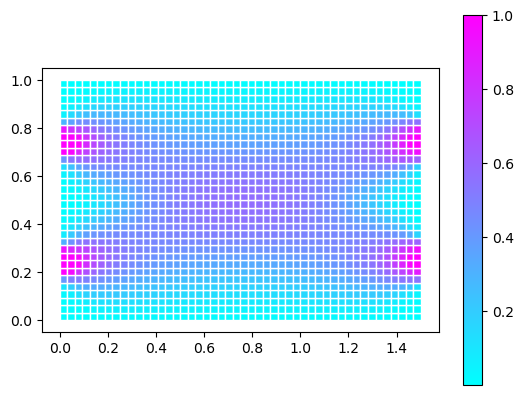

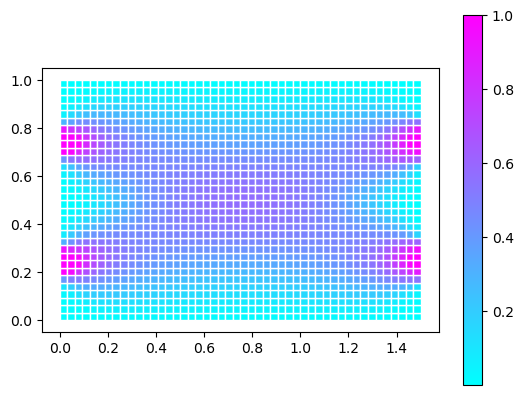

############### q = 0.01 ###############
Iteration: 1, Objective Function: 0.008156327490004047, Volume Fraction: 0.3334940337145615
Iteration: 2, Objective Function: 0.007640685107623715, Volume Fraction: 0.33336968329838806
Iteration: 3, Objective Function: 0.007227391919742558, Volume Fraction: 0.3334001657358507
Iteration: 4, Objective Function: 0.006784652608920652, Volume Fraction: 0.33316908730221434
Iteration: 5, Objective Function: 0.0063181457324649635, Volume Fraction: 0.33335373187181494


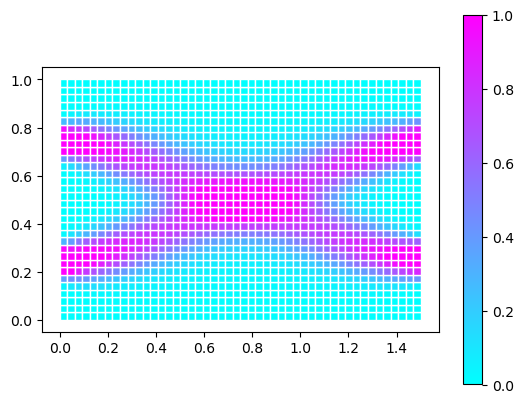

Iteration: 6, Objective Function: 0.00589505259490479, Volume Fraction: 0.3331793912987107
Iteration: 7, Objective Function: 0.005598428828918943, Volume Fraction: 0.33323495124364677
Iteration: 8, Objective Function: 0.005393361069548924, Volume Fraction: 0.33329319010051545
Iteration: 9, Objective Function: 0.005257062047305783, Volume Fraction: 0.33320630939813667
Iteration: 10, Objective Function: 0.005165710311050406, Volume Fraction: 0.3334167275236708


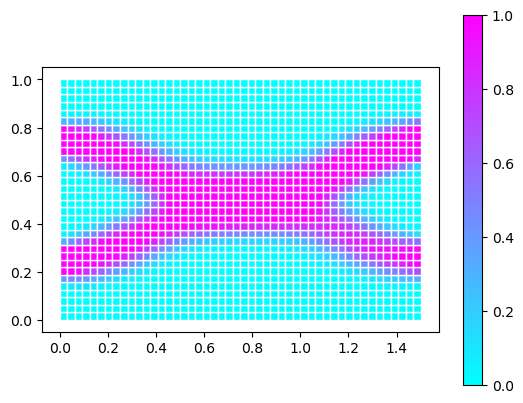

Iteration: 11, Objective Function: 0.005081725071482794, Volume Fraction: 0.3332362941888924
Iteration: 12, Objective Function: 0.005014644463595107, Volume Fraction: 0.33324160892920657
Iteration: 13, Objective Function: 0.004935164838246656, Volume Fraction: 0.33342306740883826
Iteration: 14, Objective Function: 0.004839491899432725, Volume Fraction: 0.33327795797144505
Iteration: 15, Objective Function: 0.0047435516996474515, Volume Fraction: 0.3332686013807948


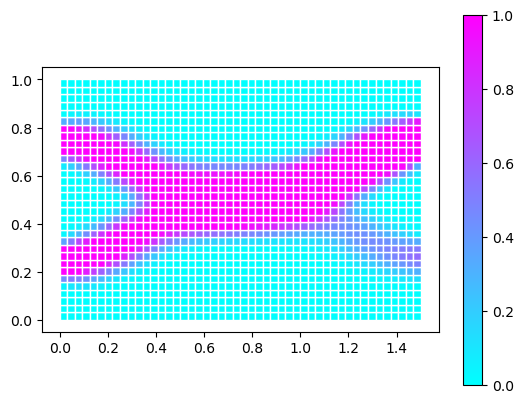

Iteration: 16, Objective Function: 0.004639200011493635, Volume Fraction: 0.333227767839057
Iteration: 17, Objective Function: 0.004539898106336826, Volume Fraction: 0.33338889595348614
Iteration: 18, Objective Function: 0.004448906647128753, Volume Fraction: 0.33336892002952373
Iteration: 19, Objective Function: 0.004379999633885485, Volume Fraction: 0.33323548133341685
Iteration: 20, Objective Function: 0.004330291836486966, Volume Fraction: 0.3334010335031293


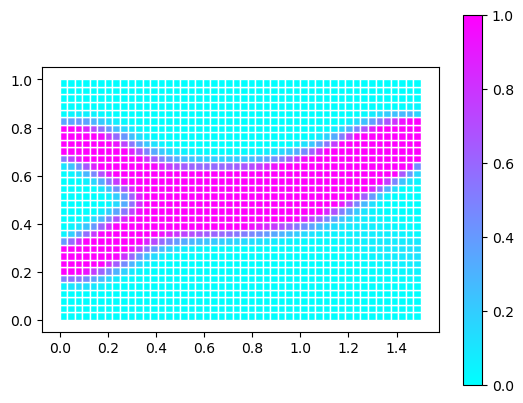

Iteration: 21, Objective Function: 0.004286737884543832, Volume Fraction: 0.3333995907065373
Iteration: 22, Objective Function: 0.004257627271864247, Volume Fraction: 0.3334210904634392
Iteration: 23, Objective Function: 0.004235068496454945, Volume Fraction: 0.33329212480022835
Iteration: 24, Objective Function: 0.004221405545785103, Volume Fraction: 0.33339518165043386
Iteration: 25, Objective Function: 0.004205953876470171, Volume Fraction: 0.3333061844866329


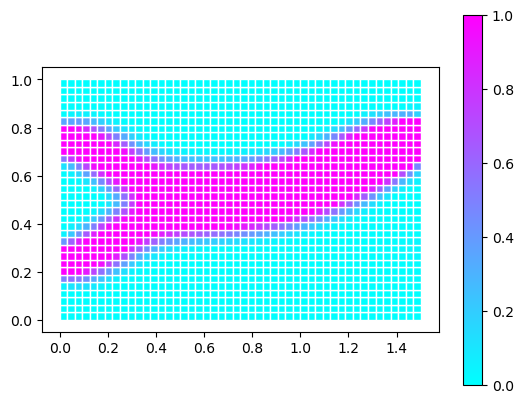

Iteration: 26, Objective Function: 0.0041975020592856255, Volume Fraction: 0.3333487433560063
Iteration: 27, Objective Function: 0.004187039179793638, Volume Fraction: 0.3332617489115788
Iteration: 28, Objective Function: 0.004180326141480974, Volume Fraction: 0.33338462401776664
Iteration: 29, Objective Function: 0.004169569588665479, Volume Fraction: 0.33337047459488733
Iteration: 30, Objective Function: 0.004163248982887906, Volume Fraction: 0.3332944404225855


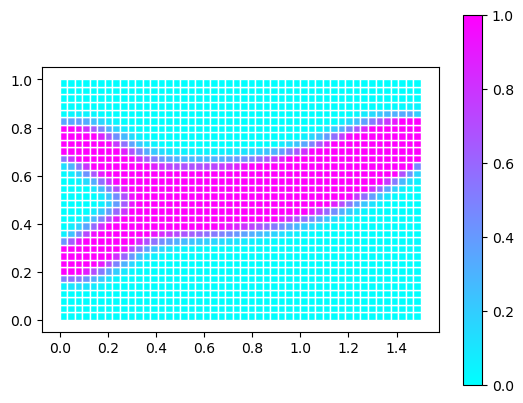

Iteration: 31, Objective Function: 0.004159310503158957, Volume Fraction: 0.3333881961791459
Iteration: 32, Objective Function: 0.0041519229467353895, Volume Fraction: 0.333321041866022
Iteration: 33, Objective Function: 0.004148814416477839, Volume Fraction: 0.3334339346807797
Iteration: 34, Objective Function: 0.004142043820864881, Volume Fraction: 0.333368767392939
Iteration: 35, Objective Function: 0.004139965728919347, Volume Fraction: 0.3332492095015405


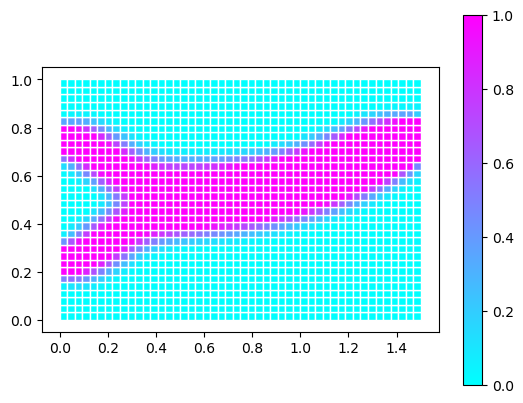

Iteration: 36, Objective Function: 0.00413918359057614, Volume Fraction: 0.3333435267653228
Iteration: 37, Objective Function: 0.004133110445398977, Volume Fraction: 0.33332177091154747
Iteration: 38, Objective Function: 0.0041296861597227095, Volume Fraction: 0.33328665347153036
Iteration: 39, Objective Function: 0.004126887679088974, Volume Fraction: 0.33323302863635657
Iteration: 40, Objective Function: 0.004125107629799958, Volume Fraction: 0.33338496922570576


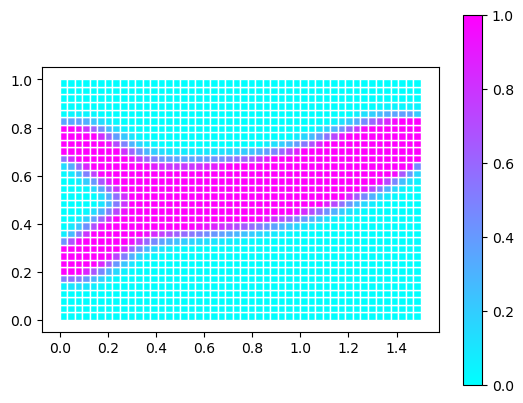

Iteration: 41, Objective Function: 0.0041190228397555, Volume Fraction: 0.33337301058838337
Iteration: 42, Objective Function: 0.004116939042042251, Volume Fraction: 0.333301596926439
Iteration: 43, Objective Function: 0.004115986697749831, Volume Fraction: 0.3332245240465589
Iteration: 44, Objective Function: 0.004114733747740651, Volume Fraction: 0.33340551316415973
Iteration: 45, Objective Function: 0.004107339801035194, Volume Fraction: 0.3332406140059962


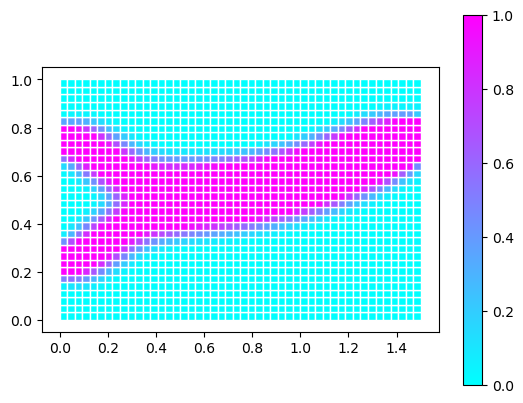

Iteration: 46, Objective Function: 0.004108211335942324, Volume Fraction: 0.3334172837314737
Iteration: 47, Objective Function: 0.004101424407187164, Volume Fraction: 0.333234912497305
Iteration: 48, Objective Function: 0.004103456085267514, Volume Fraction: 0.3333826838096259
Iteration: 49, Objective Function: 0.004098119510768007, Volume Fraction: 0.3333784061151222
Iteration: 50, Objective Function: 0.004096350996996628, Volume Fraction: 0.3333228459696655


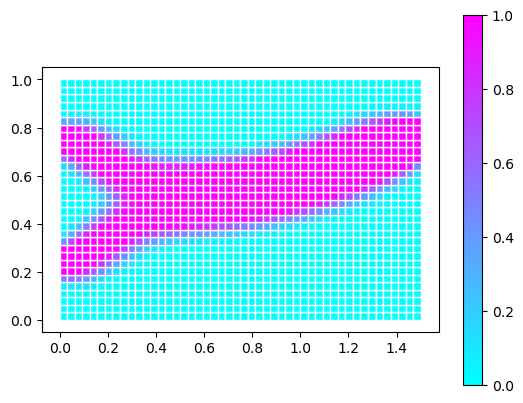

Iteration: 51, Objective Function: 0.004095833775272045, Volume Fraction: 0.33325157658978943
Iteration: 52, Objective Function: 0.004095967148579854, Volume Fraction: 0.33339196691944845
Iteration: 53, Objective Function: 0.00409144838895836, Volume Fraction: 0.33338938789216305
Iteration: 54, Objective Function: 0.004090310487390499, Volume Fraction: 0.3333417519153828
Iteration: 55, Objective Function: 0.004090172167508153, Volume Fraction: 0.3332772005599909


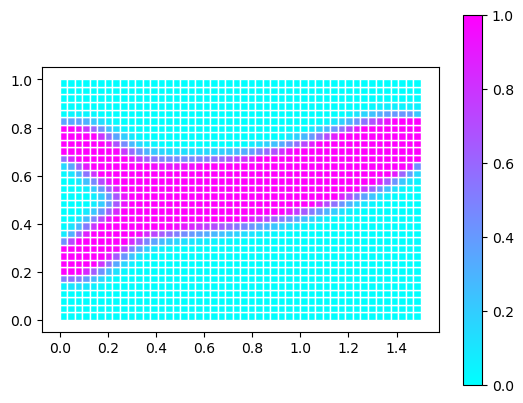

Iteration: 56, Objective Function: 0.004090242823362469, Volume Fraction: 0.3334452485306371
Iteration: 57, Objective Function: 0.004084571741790714, Volume Fraction: 0.33327116765796716
Iteration: 58, Objective Function: 0.004086620334991747, Volume Fraction: 0.33342930212901595
Iteration: 59, Objective Function: 0.004081343279523624, Volume Fraction: 0.3332452696570026
Iteration: 60, Objective Function: 0.004084259181724214, Volume Fraction: 0.3333838204057001


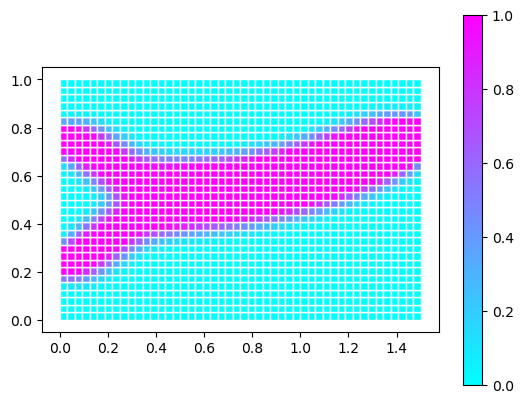

Iteration: 61, Objective Function: 0.004079713273939432, Volume Fraction: 0.33340389255264896
Iteration: 62, Objective Function: 0.004077892693817628, Volume Fraction: 0.33339272030927103
Iteration: 63, Objective Function: 0.0040769090435774915, Volume Fraction: 0.3333689025467759
Iteration: 64, Objective Function: 0.004076275438522688, Volume Fraction: 0.3333404538802924
Iteration: 65, Objective Function: 0.0040758976923692455, Volume Fraction: 0.3333073278625685


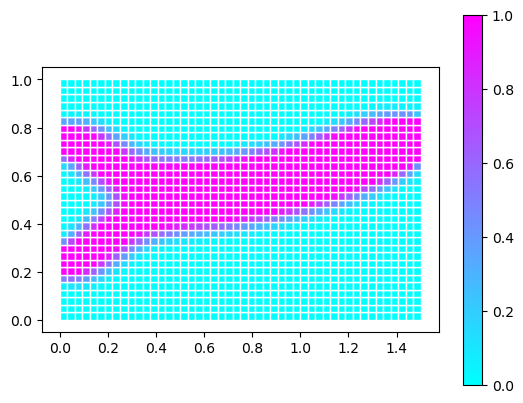

Iteration: 66, Objective Function: 0.004075882879089671, Volume Fraction: 0.3332514739858811
Iteration: 67, Objective Function: 0.004076561958323557, Volume Fraction: 0.33340342024928216
Iteration: 68, Objective Function: 0.004072512654875076, Volume Fraction: 0.33341041850580916


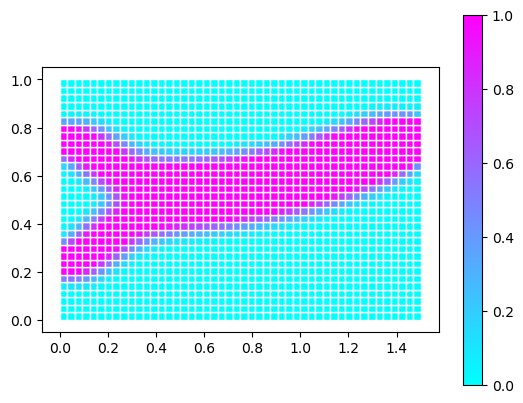

############### q = 0.1 ################
Iteration: 1, Objective Function: 0.0065250418300215815, Volume Fraction: 0.33332224748015266
Iteration: 2, Objective Function: 0.005740937288415823, Volume Fraction: 0.33332184458801545
Iteration: 3, Objective Function: 0.005588332523015034, Volume Fraction: 0.3333384074939592
Iteration: 4, Objective Function: 0.005549960628659168, Volume Fraction: 0.3333144075433318
Iteration: 5, Objective Function: 0.005535297105415015, Volume Fraction: 0.3333188663551066


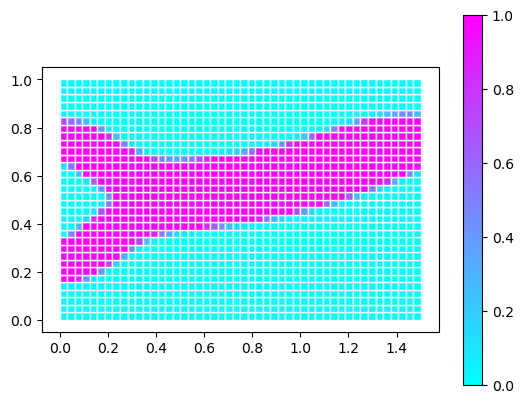

Iteration: 6, Objective Function: 0.005526469019776388, Volume Fraction: 0.3333381989715772
Iteration: 7, Objective Function: 0.005520013000155849, Volume Fraction: 0.33333716408700137
Iteration: 8, Objective Function: 0.005515953105700121, Volume Fraction: 0.33334945241351405
Iteration: 9, Objective Function: 0.005512173372442535, Volume Fraction: 0.3333233489864638
Iteration: 10, Objective Function: 0.005510485824412789, Volume Fraction: 0.33333703728663755


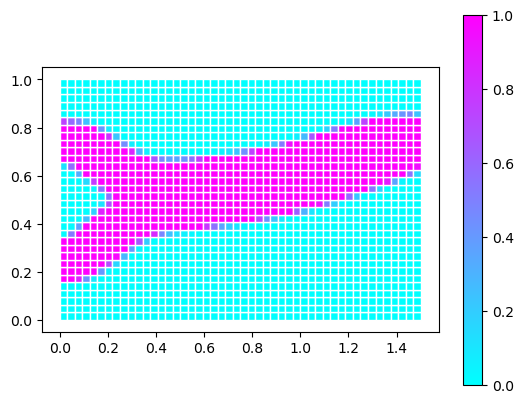

Iteration: 11, Objective Function: 0.0055074316687097145, Volume Fraction: 0.333351799939894
Iteration: 12, Objective Function: 0.0055045367777943515, Volume Fraction: 0.3333278220180584
Iteration: 13, Objective Function: 0.005503364200478403, Volume Fraction: 0.33331716641907866
Iteration: 14, Objective Function: 0.005501691369324348, Volume Fraction: 0.33333834878075597
Iteration: 15, Objective Function: 0.005498859529520336, Volume Fraction: 0.33333512994212827


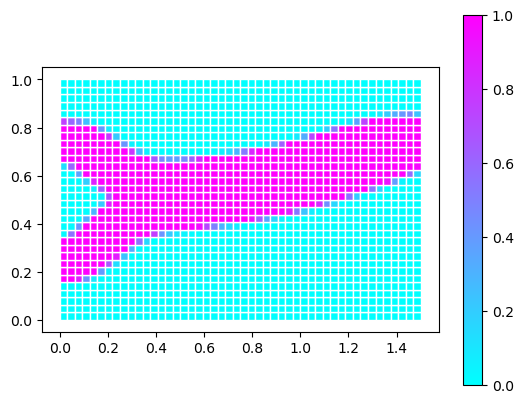

Iteration: 16, Objective Function: 0.005497155110500321, Volume Fraction: 0.33332317378452636
Iteration: 17, Objective Function: 0.005495880204345712, Volume Fraction: 0.33335190410181365
Iteration: 18, Objective Function: 0.0054929421418800205, Volume Fraction: 0.3333398107443764
Iteration: 19, Objective Function: 0.005491719700826766, Volume Fraction: 0.3333214340882387
Iteration: 20, Objective Function: 0.0054908209887869945, Volume Fraction: 0.33334684405499754


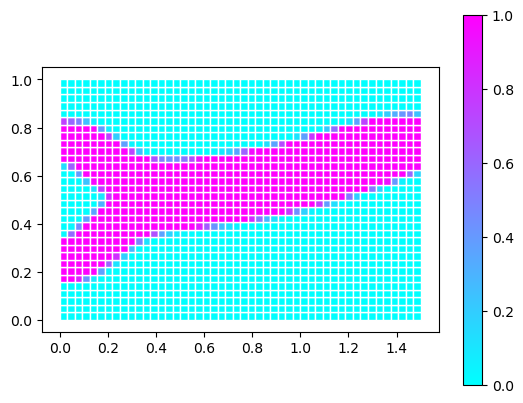

Iteration: 21, Objective Function: 0.005488116248154534, Volume Fraction: 0.33333027386780206
Iteration: 22, Objective Function: 0.005487151489181897, Volume Fraction: 0.33331501184730633
Iteration: 23, Objective Function: 0.005486159551650021, Volume Fraction: 0.333342817181435
Iteration: 24, Objective Function: 0.005483407071661542, Volume Fraction: 0.33333147059104284
Iteration: 25, Objective Function: 0.005482320012130167, Volume Fraction: 0.3333255508901106


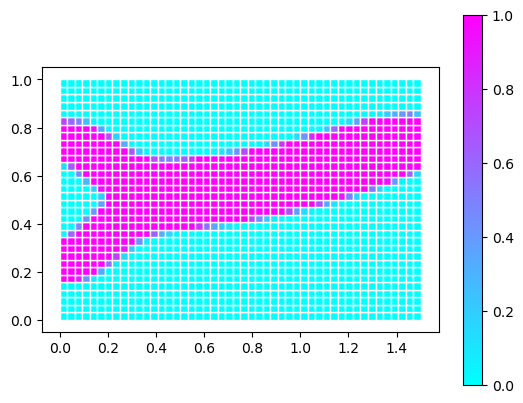

Iteration: 26, Objective Function: 0.0054810605549209905, Volume Fraction: 0.33333830630889166
Iteration: 27, Objective Function: 0.005479186463957761, Volume Fraction: 0.3333240580506388
Iteration: 28, Objective Function: 0.005478592480454469, Volume Fraction: 0.33333081839307055
Iteration: 29, Objective Function: 0.005477243295784631, Volume Fraction: 0.3333250996877784
Iteration: 30, Objective Function: 0.005476469376326041, Volume Fraction: 0.3333166215062075


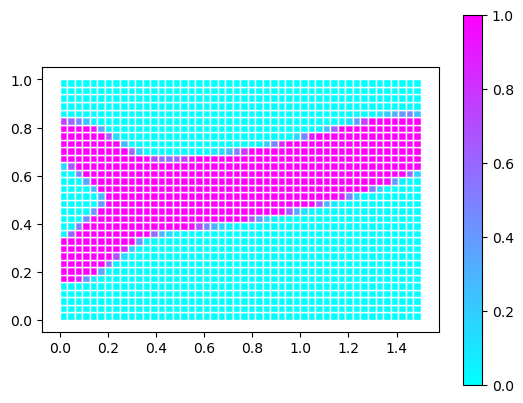

Iteration: 31, Objective Function: 0.005475833319943817, Volume Fraction: 0.333347745850634
Iteration: 32, Objective Function: 0.0054735467459751524, Volume Fraction: 0.3333337150233921
Iteration: 33, Objective Function: 0.005473096477318597, Volume Fraction: 0.3333353266627816
Iteration: 41, Objective Function: 0.0054631725991941115, Volume Fraction: 0.33334445691325776
Iteration: 42, Objective Function: 0.0054605535365203645, Volume Fraction: 0.3333189437927086
Iteration: 43, Objective Function: 0.005460402704037494, Volume Fraction: 0.33334358102683154
Iteration: 44, Objective Function: 0.005458446028241195, Volume Fraction: 0.333328608733638
Iteration: 45, Objective Function: 0.005458207021282676, Volume Fraction: 0.33333067484587936


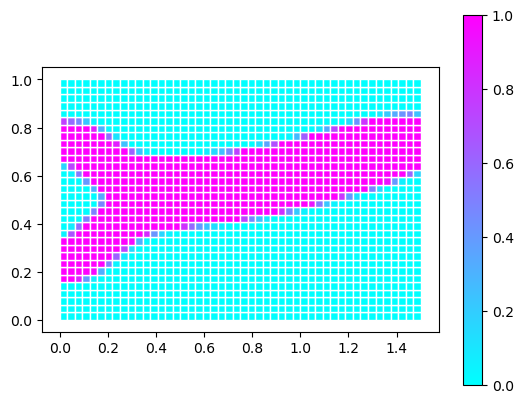

Iteration: 46, Objective Function: 0.005457349826411032, Volume Fraction: 0.33334846388697925
Iteration: 47, Objective Function: 0.005455925379323347, Volume Fraction: 0.33333935797624425
Iteration: 48, Objective Function: 0.005455658482589247, Volume Fraction: 0.33335230885007466
Iteration: 49, Objective Function: 0.005454549076174755, Volume Fraction: 0.33334010577947676
Iteration: 50, Objective Function: 0.0054545049453444995, Volume Fraction: 0.3333503926044645


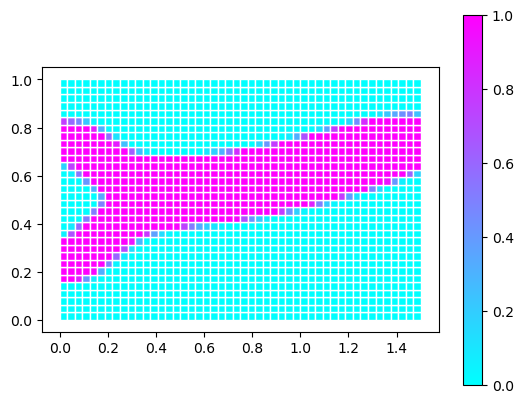

Iteration: 51, Objective Function: 0.005453585075230255, Volume Fraction: 0.3333390041607862
Iteration: 52, Objective Function: 0.005453573879895342, Volume Fraction: 0.33331374255713675
Iteration: 53, Objective Function: 0.005454148704919549, Volume Fraction: 0.33331865934919497
Iteration: 54, Objective Function: 0.005453527547919373, Volume Fraction: 0.33334640145314226
Iteration: 55, Objective Function: 0.00545200826897655, Volume Fraction: 0.33331375026182203


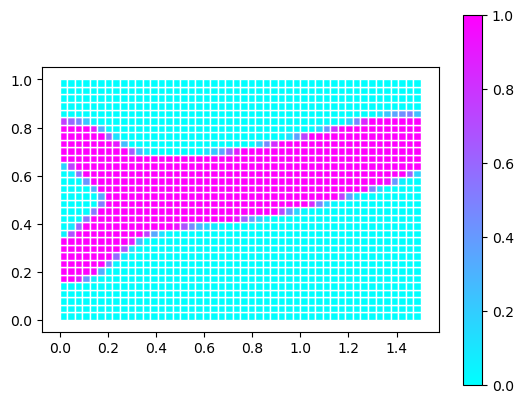

Iteration: 56, Objective Function: 0.005452936998525907, Volume Fraction: 0.33331858172331463
Iteration: 57, Objective Function: 0.005452365797988168, Volume Fraction: 0.33335078229859844
Iteration: 58, Objective Function: 0.005450701093848061, Volume Fraction: 0.3333255406140403
Iteration: 59, Objective Function: 0.00545134479535837, Volume Fraction: 0.3333405066158624
Iteration: 60, Objective Function: 0.00545036837059119, Volume Fraction: 0.3333452928270298


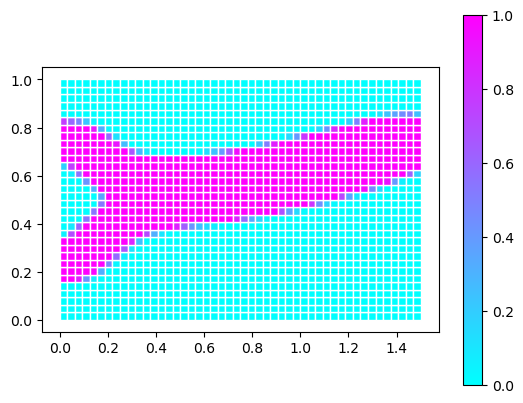

Iteration: 61, Objective Function: 0.0054497921611559065, Volume Fraction: 0.33334496943751146
Iteration: 62, Objective Function: 0.005449408833902962, Volume Fraction: 0.33334263544965087
Iteration: 63, Objective Function: 0.005449091480427199, Volume Fraction: 0.3333404489304291
Iteration: 64, Objective Function: 0.005448751265810739, Volume Fraction: 0.33333918112451166
Iteration: 65, Objective Function: 0.0054483543939122855, Volume Fraction: 0.33333456031151437


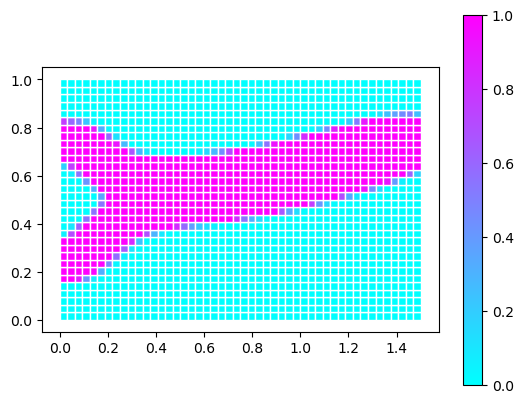

Iteration: 66, Objective Function: 0.005448072068509545, Volume Fraction: 0.3333256849754907
Iteration: 67, Objective Function: 0.0054479493145020395, Volume Fraction: 0.3333179345341149
Iteration: 68, Objective Function: 0.005447775446034076, Volume Fraction: 0.3333521457946608
Iteration: 69, Objective Function: 0.00544592441200764, Volume Fraction: 0.33333836614797807
Iteration: 70, Objective Function: 0.005446014110591789, Volume Fraction: 0.3333318356214277


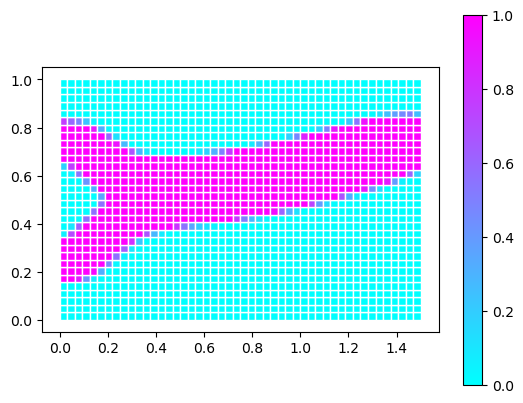

Iteration: 71, Objective Function: 0.005445838599144679, Volume Fraction: 0.333330200485795
Iteration: 72, Objective Function: 0.005445494474069, Volume Fraction: 0.3333245166619862
Iteration: 73, Objective Function: 0.005445348639908955, Volume Fraction: 0.33331854984533854
Iteration: 74, Objective Function: 0.005445246152369744, Volume Fraction: 0.33335176486049206
Iteration: 75, Objective Function: 0.005443597721934246, Volume Fraction: 0.33333224225940267


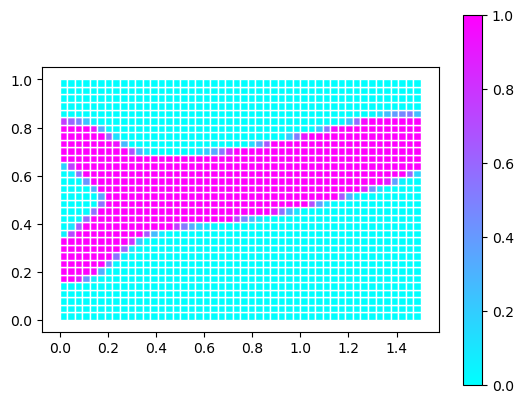

Iteration: 76, Objective Function: 0.005444078426905767, Volume Fraction: 0.3333162957851414
Iteration: 77, Objective Function: 0.0054444247376368785, Volume Fraction: 0.33334233946002995
Iteration: 78, Objective Function: 0.005443093626473229, Volume Fraction: 0.3333196212685335
Iteration: 79, Objective Function: 0.005443717737745355, Volume Fraction: 0.33334309838645565


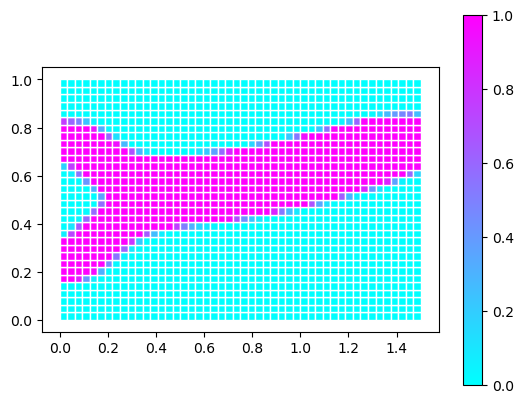

################ q = 1 #################
Iteration: 1, Objective Function: 0.006191775690396889, Volume Fraction: 0.3333428388471848
Iteration: 2, Objective Function: 0.006015224159161785, Volume Fraction: 0.33333865449390404
Iteration: 3, Objective Function: 0.0059237000118288734, Volume Fraction: 0.3333336530189137
Iteration: 4, Objective Function: 0.005860757780159464, Volume Fraction: 0.3333341321182539
Iteration: 5, Objective Function: 0.005837442673677964, Volume Fraction: 0.3333362837887646


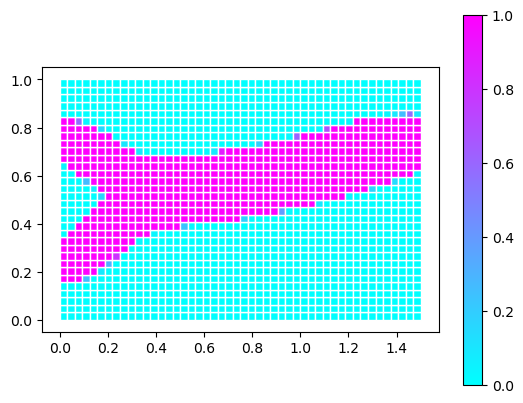

Iteration: 6, Objective Function: 0.005824133078707005, Volume Fraction: 0.3333309856933067
Iteration: 7, Objective Function: 0.005812974622527503, Volume Fraction: 0.3333334473432908
Iteration: 8, Objective Function: 0.005804575124891907, Volume Fraction: 0.33333343931657833
Iteration: 9, Objective Function: 0.00579707527627261, Volume Fraction: 0.3333323855372922
Iteration: 10, Objective Function: 0.005790122667703575, Volume Fraction: 0.33333266061005523


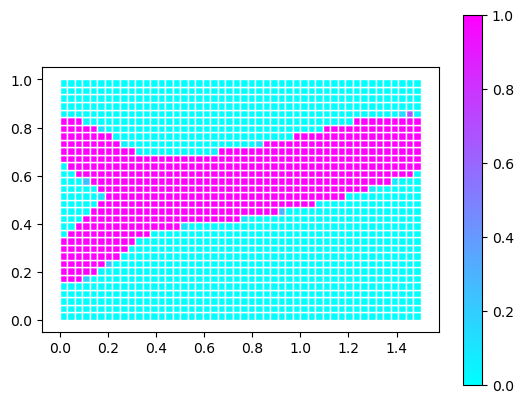

Iteration: 11, Objective Function: 0.0057894657842770935, Volume Fraction: 0.3333333597116293
Iteration: 12, Objective Function: 0.005788813796393987, Volume Fraction: 0.333332383320031
Iteration: 13, Objective Function: 0.005788205469115855, Volume Fraction: 0.3333321687556484
Iteration: 14, Objective Function: 0.005787505843785347, Volume Fraction: 0.33333432283605946
Iteration: 15, Objective Function: 0.005786566344352553, Volume Fraction: 0.33333244525634803


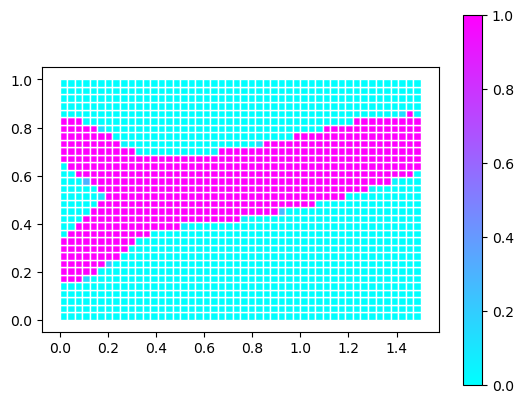

Iteration: 16, Objective Function: 0.005785769249593982, Volume Fraction: 0.33333364610039196
Iteration: 17, Objective Function: 0.0057855283231271655, Volume Fraction: 0.3333338466567283
Iteration: 18, Objective Function: 0.005785328717652311, Volume Fraction: 0.33333301405431176
Iteration: 19, Objective Function: 0.005785169404211006, Volume Fraction: 0.3333333660469278
Iteration: 20, Objective Function: 0.0057849707362506615, Volume Fraction: 0.3333328735331288


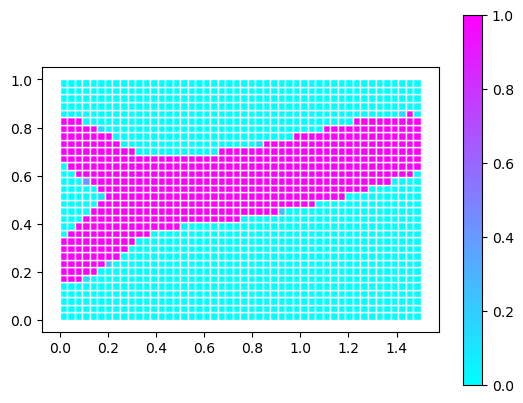

Iteration: 21, Objective Function: 0.005784800052459151, Volume Fraction: 0.33333391835993625
Iteration: 22, Objective Function: 0.0057845698839390815, Volume Fraction: 0.3333326011730677
Iteration: 23, Objective Function: 0.005784412727760767, Volume Fraction: 0.33333369983341266
Iteration: 24, Objective Function: 0.005784152305662341, Volume Fraction: 0.3333338665411276
Iteration: 25, Objective Function: 0.005783897169632311, Volume Fraction: 0.3333343375395364


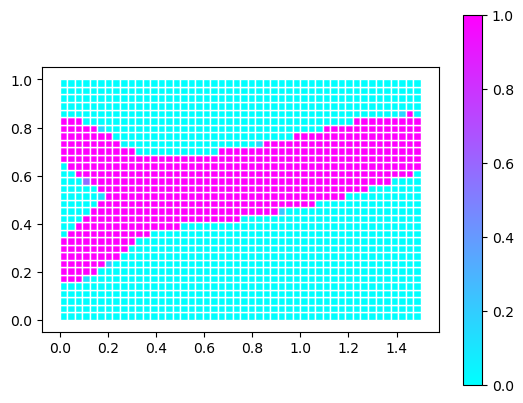

Iteration: 26, Objective Function: 0.0057835872757030764, Volume Fraction: 0.3333328965862507
Iteration: 27, Objective Function: 0.005783279146572493, Volume Fraction: 0.3333324518056306
Iteration: 28, Objective Function: 0.005782822433831177, Volume Fraction: 0.3333338899001587
Iteration: 29, Objective Function: 0.0057820960605682176, Volume Fraction: 0.333334221208343
Iteration: 30, Objective Function: 0.00578104110966353, Volume Fraction: 0.3333328246551048


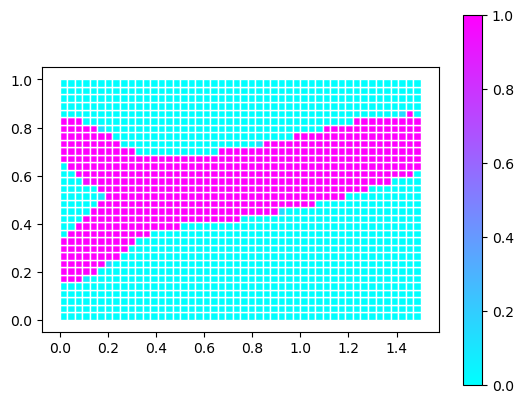

Iteration: 31, Objective Function: 0.005779297966238122, Volume Fraction: 0.33333345684012433
Iteration: 32, Objective Function: 0.00577800965089457, Volume Fraction: 0.33333328256378036


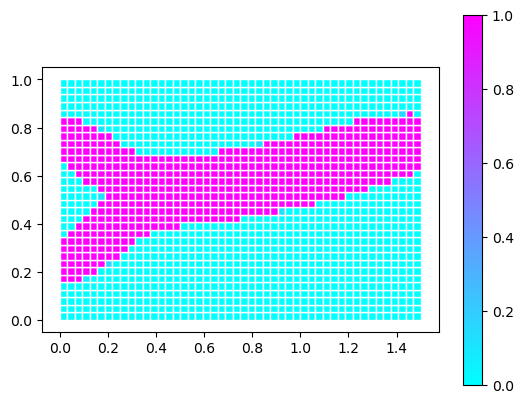

In [10]:
poly_top = PolyTop(fem)
poly_top.optimize(density_initial, density_min, density_max, volume_fraction_max,
                  design_tolerance, max_iterations, q_values,
                  opt_OCMove, opt_OCEta)

### Evaluation

Objective Function:0.005800455313224959, Volume fraction:0.3326822916666667


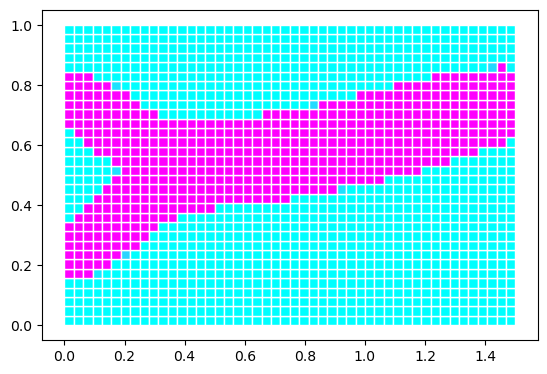

In [11]:
z = poly_top.fem.density
check=[]
for i in range(len(z)):
    if z[i]<=0.5:
        check.append(0)
    else:
        check.append(1)
z_hev=np.array(check)
epsilon = 8*(10**-2)
E_eva = 1./epsilon*(1-z_hev)*1/(1+z_hev)
_, _, _, _, _, f_eva = poly_top.fem.solve(E_eva)
print(f'Objective Function:{f_eva}, Volume fraction:{sum(check)/poly_top.fem.mesh_p.area}')
Q2Q1FEM.Plot_patch(n_elem_for_height,coords,elements,z,1.,0,cmap='cool')

## Optimization with Annealing

In [14]:
from amplify.client import FixstarsClient
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
client.token = 'token '
#client.proxy = ''

annealing_solver = AnnealingSolver(client)

In [11]:
dis = 1.
reg = 2.
char = 25.
vol_list = [0.1,0.1,0.1,0.1,0.1,0.1,1.,1.,1.,5.,5.,5.,10.,10.,10.,50.,50.,50.]
iterations = len(vol_list)

Iteration: 0, Objective Function: 0.001445411473601992, Volume Fraction: 0.7933304398148125
0.9290093052206245 0.21497931977820184


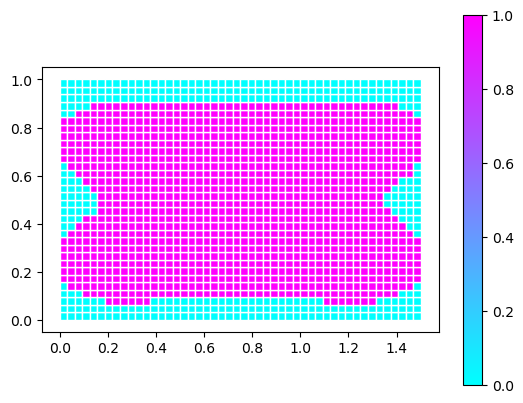

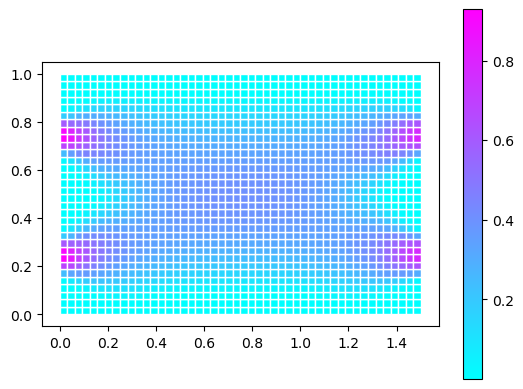

Iteration: 1, Objective Function: 0.0017781200899374418, Volume Fraction: 0.6922743055555548
0.9349592573890051 0.21591897085696932


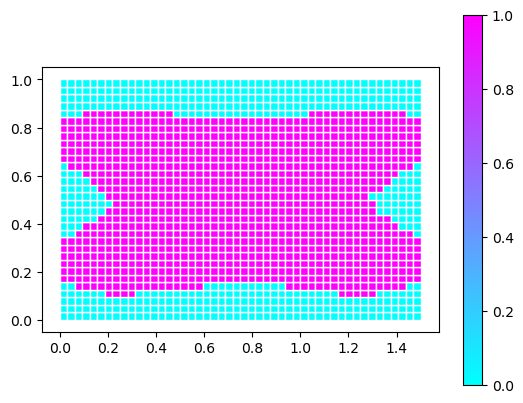

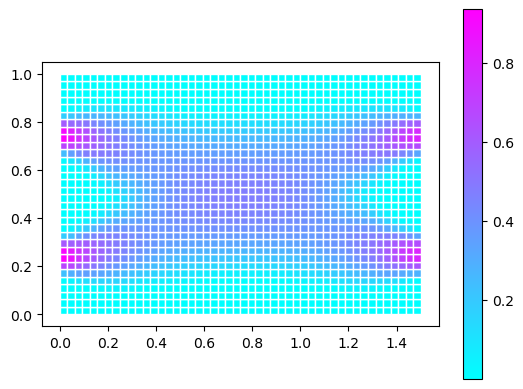

Iteration: 2, Objective Function: 0.002090654952978806, Volume Fraction: 0.6236255787037049
0.939386245516281 0.22109936180490647


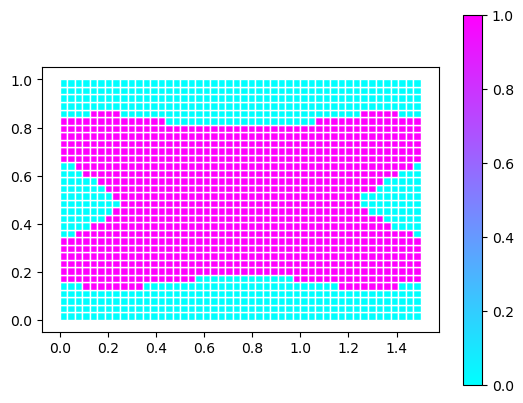

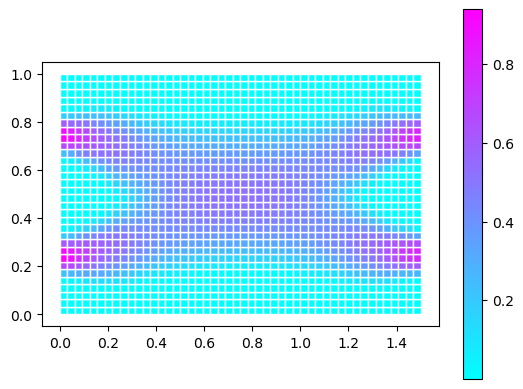

Iteration: 3, Objective Function: 0.0023726726172827433, Volume Fraction: 0.575737847222224
0.9394833622853243 0.23974736329877297


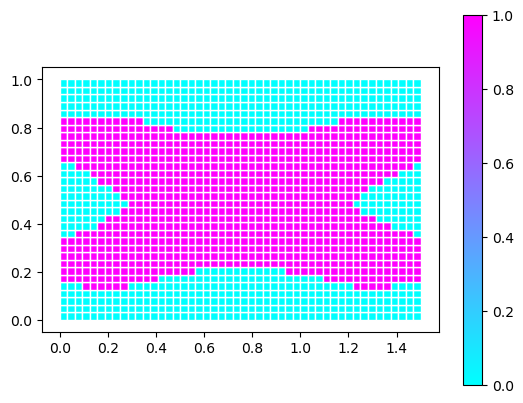

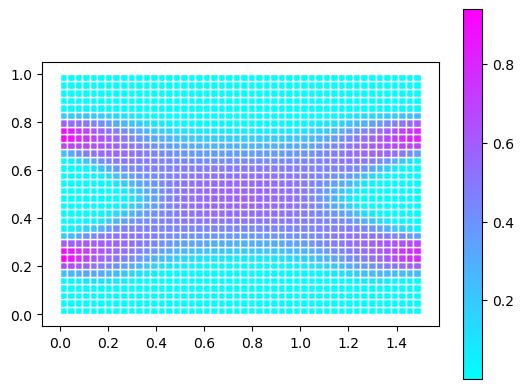

Iteration: 4, Objective Function: 0.0026212256409679354, Volume Fraction: 0.5465133101851868
0.9394891427692207 0.2571172767803344


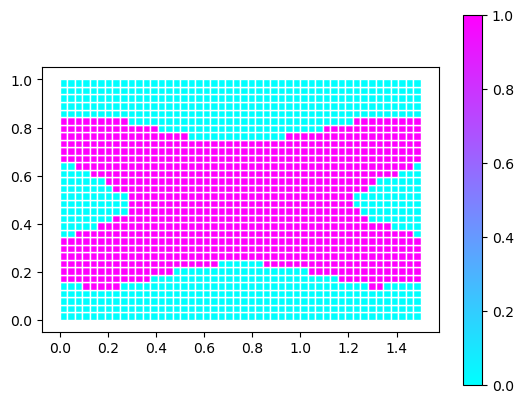

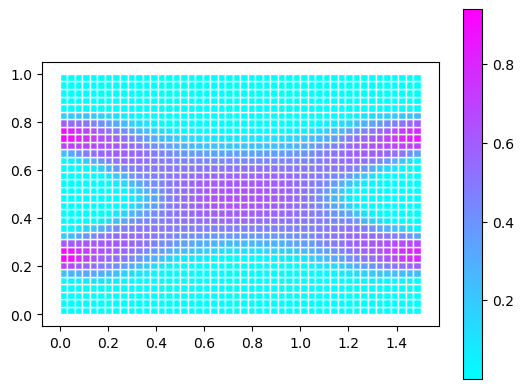

Iteration: 5, Objective Function: 0.002769353458223733, Volume Fraction: 0.5283564814814838
0.9394954949874104 0.2783682805158275


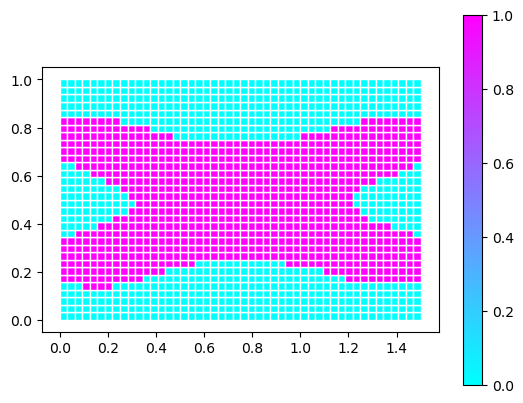

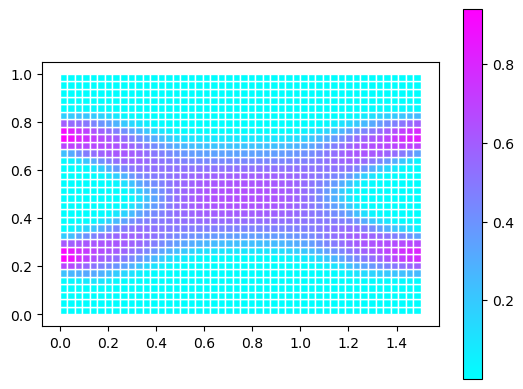

Iteration: 6, Objective Function: 0.004487617338136069, Volume Fraction: 0.44039351851852104
0.9484661137981774 0.36697210801525976


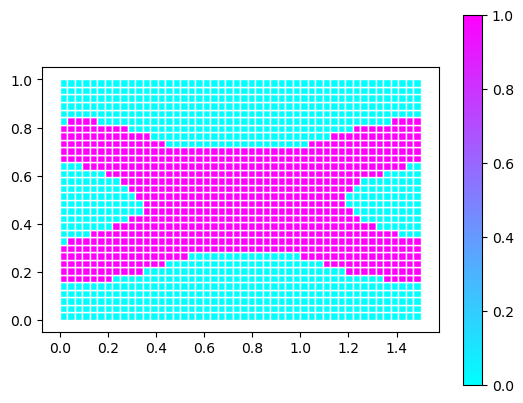

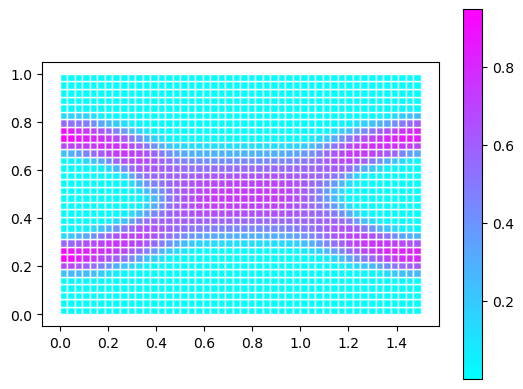

Iteration: 7, Objective Function: 0.005816181631916492, Volume Fraction: 0.39496527777777973
0.9489174202677005 0.41600812017299704


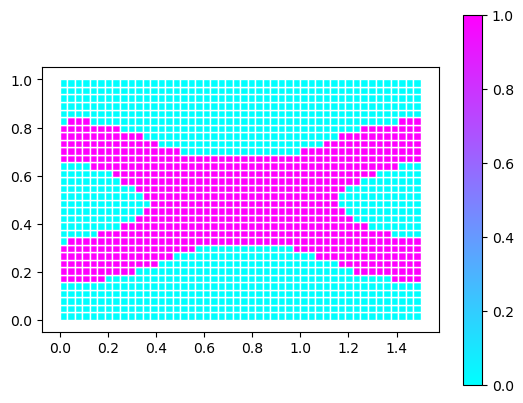

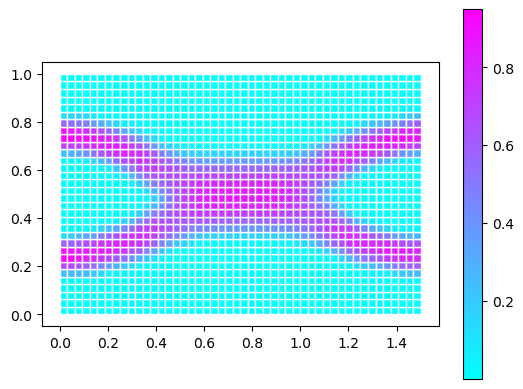

Iteration: 8, Objective Function: 0.006348122709919829, Volume Fraction: 0.3831741898148169
0.949701069091392 0.4273542083765269


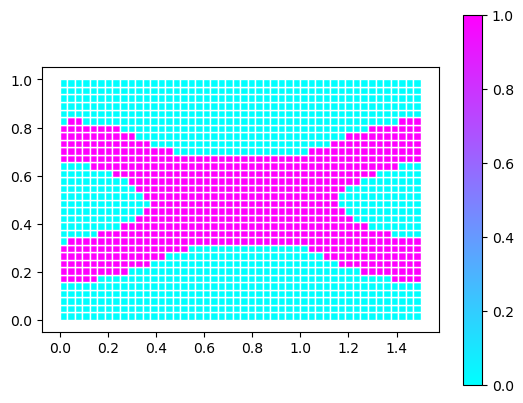

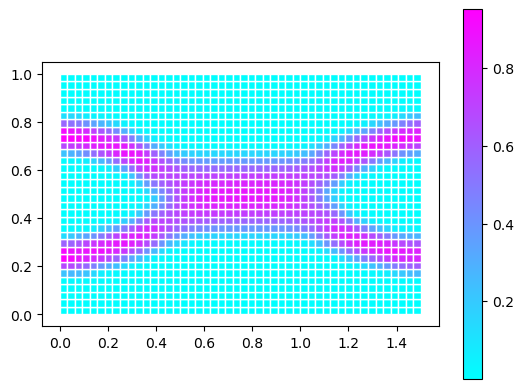

Iteration: 9, Objective Function: 0.008625975078374157, Volume Fraction: 0.3408564814814825
1.0155203103699666 0.4649827050458111


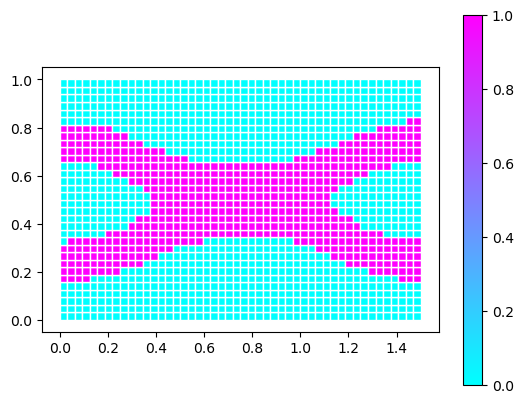

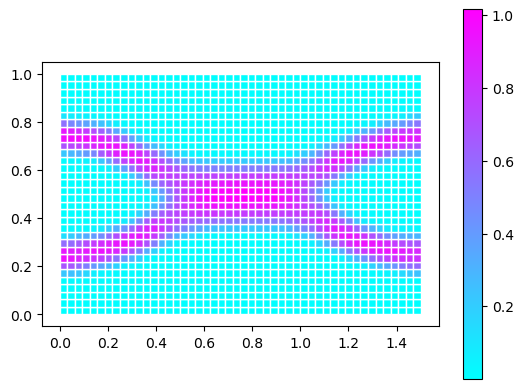

Iteration: 10, Objective Function: 0.009065405413159571, Volume Fraction: 0.3353587962962971
1.0155143288888855 0.4866906652989409


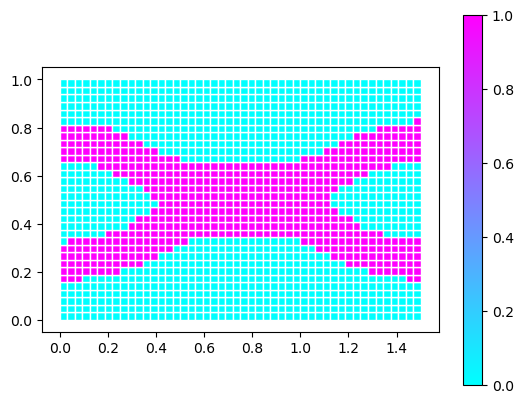

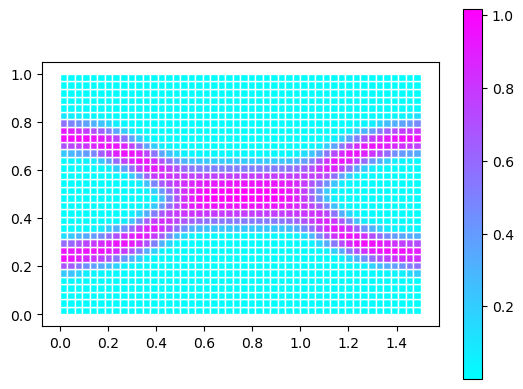

Iteration: 11, Objective Function: 0.009189902482375044, Volume Fraction: 0.33347800925926
1.0151643625254203 0.5065158396899743


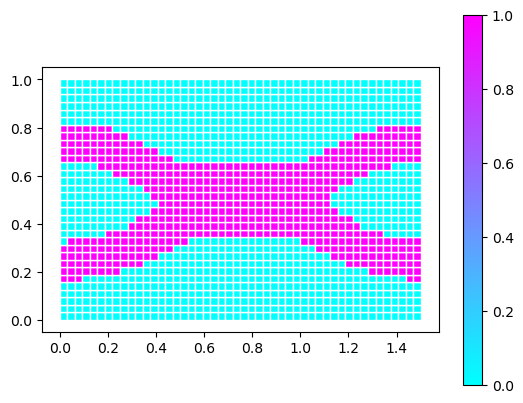

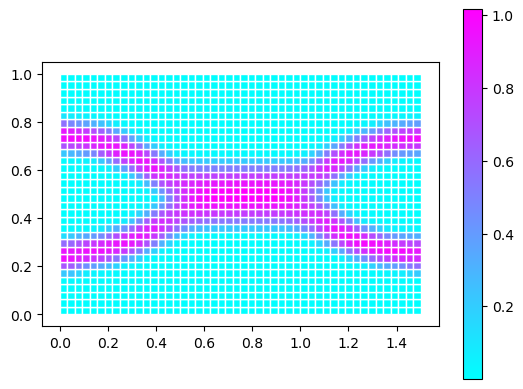

Iteration: 12, Objective Function: 0.009658169329887528, Volume Fraction: 0.3289930555555562
1.0147841733448806 0.5380570462213341


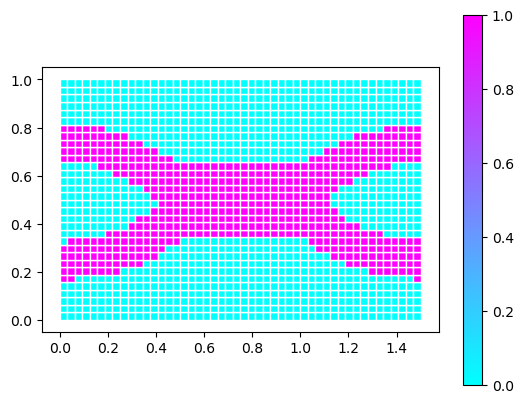

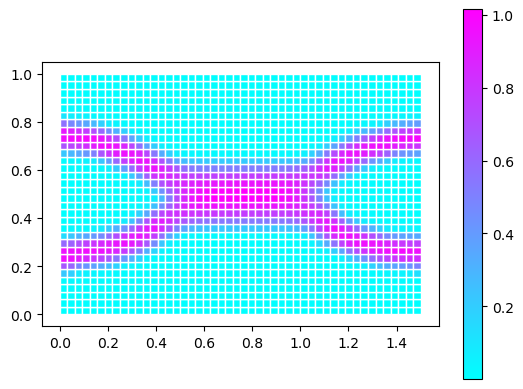

Iteration: 13, Objective Function: 0.009753968373652153, Volume Fraction: 0.3281973379629635
1.0147405626352834 0.5380241228119798


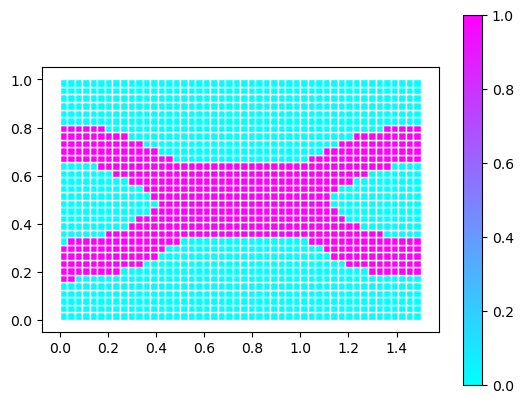

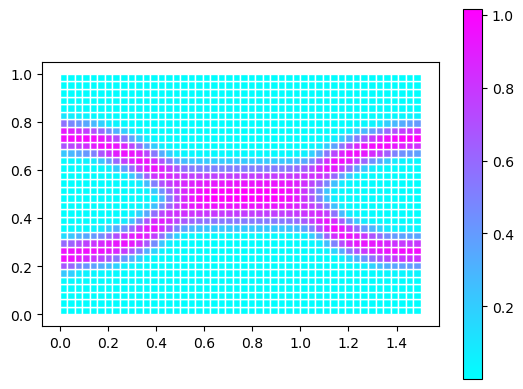

Iteration: 14, Objective Function: 0.009753968373652153, Volume Fraction: 0.3281973379629635
1.0147405626352834 0.5380241228119798


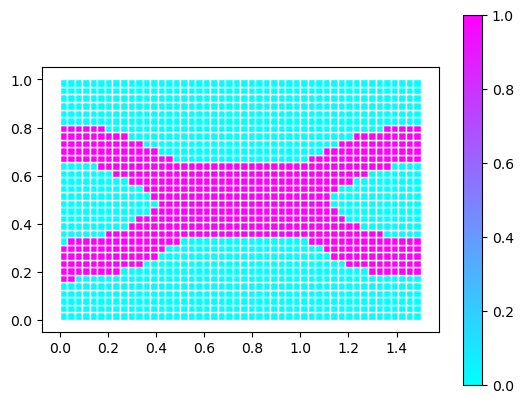

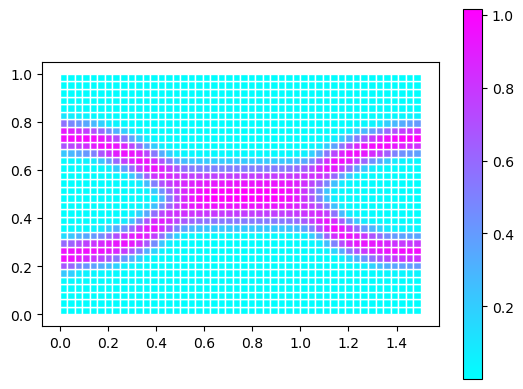

In [12]:
annealing_optimizer = AnnealingParameterTuning(fem)
annealing_optimizer.optimize(annealing_solver, 
                             density_initial_QA, density_min, density_max, volume_fraction_max, dis, reg, char, vol_list, iterations)

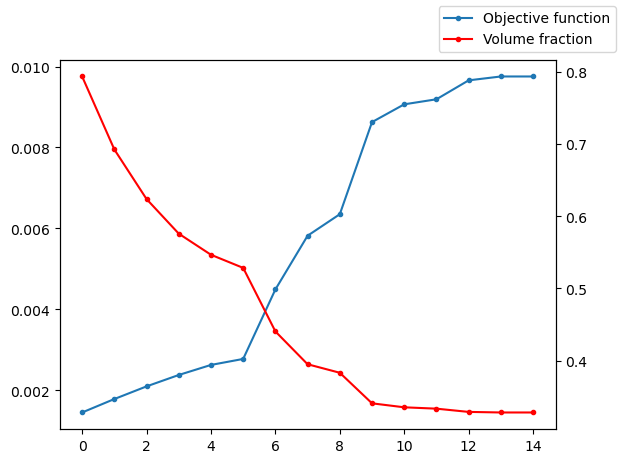

In [13]:
annealing_optimizer.plot_history()